In [2]:
import PyPDF2
import os
import re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import networkx as nx
from collections import defaultdict, Counter
import community.community_louvain as community_louvain
from pyvis.network import Network
import plotly.graph_objs as go
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

True

In [3]:
!pip install PyPDF2==3.0.0
!pip install pyCryptodome
!pip install re
!pip install numpy
!pip install pandas
!pip install nltk
!pip install wordcloud
!pip install matplotlib
!pip install Textblobb
!pip install gensim
!pip install networkx
!pip install community
!pip install pyvis
!pip install plotly
!pip install sklearn



  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [4]:
# Ler o arquivo PDF
def read_pdf(file_path):
    with open(file_path , 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page in reader.pages:
            text += page.extract_text()
    return text

# Limpeza do texto
def clean_text(text, use_lemmatization=True):
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\[\d+\]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words_pt = set(stopwords.words('portuguese'))
    stop_words_en = set(stopwords.words('english'))
    stop_words = stop_words_pt.union(stop_words_en)
    words = [word for word in tokens if word not in stop_words and len(word) > 2]

    if use_lemmatization:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(token) for token in words]

    return words

In [5]:
# Funções de Análise e Visualização
def word_frequency(words):
    df = pd.DataFrame(words, columns=['word'])
    freq = df.groupby('word').size().reset_index(name='frequency')
    return freq.sort_values('frequency', ascending=False)

def sentiment_analysis(words,vader=True):
    text = ' '.join(words)
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if vader:
        # Inicializando o vader
        vader_analizer= SentimentIntensityAnalyzer()
        # calcula as pontuacoes de sentimento
        scores= vader_analizer.polarity_scores(text)
        compound= scores['compound']
        #print(f'Resultado Compound {compound} scores: {scores}')

        # Interpretacao com base no compound:
        if compound >=0.05:
            return ' Positivo'
        elif compound <=-0.05:
            return 'Negativo'
        else:
            return 'Neutro'
    return 'Positivo' if sentiment > 0 else 'Negativo' if sentiment < 0 else 'Neutro'

def generate_wordcloud(words):
    text = ' '.join(words)
    if len(text.split()) == 0:
        print("O texto está vazio após a limpeza. A nuvem de palavras não pode ser gerada.")
        return
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(text)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig('wordcloud.png')
    plt.show()
    plt.close()

# LDA e Coerência
def find_optimal_number_of_topics(clean_text, start=5, limit=20, step=5):
    dictionary = Dictionary([clean_text])
    corpus = [dictionary.doc2bow(clean_text)]
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15)
        model_list.append(model)
        coherence_model_lda = CoherenceModel(model=model, texts=[clean_text], dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())

    return model_list, coherence_values

def plot_coherence(coherence_values, start=5, limit=20, step=5):
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Número de Tópicos")
    plt.ylabel("Coerência")
    plt.title("Coerência em relação ao número de tópicos")
    plt.show()

def word_network_with_weights(text, lda_model, dictionary):
    text = ' '.join(text)
    words = text.split()
    word_pairs = [(words[i], words[i + 1]) for i in range(len(words) - 1)]
    weights = defaultdict(float)

    for word1, word2 in word_pairs:
        bow1 = dictionary.doc2bow([word1])
        bow2 = dictionary.doc2bow([word2])
        for topic_num, prob in lda_model.get_document_topics(bow1, minimum_probability=0):
            for topic_num2, prob2 in lda_model.get_document_topics(bow2, minimum_probability=0):
                if topic_num == topic_num2:
                    weights[(word1, word2)] += (prob + prob2) / 2

    G = nx.Graph()
    for (word1, word2), weight in weights.items():
        if weight > 0:
            G.add_edge(word1, word2, weight=weight)
    return G

In [6]:
def filter_nodes_by_degree_centrality(G, threshold=0.01):
    centrality = nx.degree_centrality(G)
    nodes_to_remove = [n for n, c in centrality.items() if c < threshold]
    G_filtered = G.copy()
    G_filtered.remove_nodes_from(nodes_to_remove)
    return G_filtered

def filter_edges_by_weight(G, weight_threshold=0.5):
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d.get('weight', 0) < weight_threshold]
    G_filtered = G.copy()
    G_filtered.remove_edges_from(edges_to_remove)
    return G_filtered

def detect_comunnities_louvain(G):
    partition = community_louvain.best_partition(G)
    return partition

def filter_graph_by_community(G, communities, top_n=3):
    communities_counts = Counter(communities.values())
    top_communities = [c for c, _ in communities_counts.most_common(top_n)]
    nodes_to_keep = [n for n in G.nodes if communities[n] in top_communities]
    G_filtered = G.subgraph(nodes_to_keep)
    return G_filtered
# Comparando documentos
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


def compare_documents(doc1, doc2, lda_model1, lda_model2, dictionary1, dictionary2):
    # Gerar vetores de tópicos para o primeiro documento
    bow1 = dictionary1.doc2bow(doc1)
    vector1 = [prob for _, prob in lda_model1.get_document_topics(bow1, minimum_probability=0)]

    # Gerar vetores de tópicos para o segundo documento
    bow2 = dictionary2.doc2bow(doc2)
    vector2 = [prob for _, prob in lda_model2.get_document_topics(bow2, minimum_probability=0)]

    # Padronizar os vetores para o mesmo tamanho
    max_len = max(len(vector1), len(vector2))
    vector1 = np.pad(vector1, (0, max_len - len(vector1)))
    vector2 = np.pad(vector2, (0, max_len - len(vector2)))

    # Calcular a similaridade de cosseno
    similarity = cosine_similarity([vector1], [vector2])[0][0]
    return similarity


#Predicao de sentimentos ao longo do tempo no texto
# Criacaod e uma janela movel
def sentiment_over_time(text,window_size=100,window_topic=False):
    chunks= [text[i:i+window_size]for i in range(0,len(text))]
    sentiments= [sentiment_analysis(chunk) for chunk in chunks]

    #Transformar positivo, neutro e negativo em valores numericos
    sentiment_values=[1 if s=='Positivo' else -1 if s== 'Negativo' else 0 for s in sentiments]
    #Plotagem
    plt.plot(range(len(sentiments)), sentiment_values, marker='o')
    plt.title('Sentimento ao longo do texto')
    plt.xlabel('Partes do Texto')
    plt.ylabel('Sentimento (Positivo = 1, Neutro = 0, Negativo = -1)')
    plt.show()
    if window_topic == True:
        _,model_topics= find_optimal_number_of_topics(text)
        lenght_topic= len(model_topics)
        chunks = [text[i:i + lenght_topic] for i in range(0, len(text))]
        sentiments = [sentiment_analysis(chunk) for chunk in chunks]

        # Transformar positivo, neutro e negativo em valores numericos
        sentiment_values = [1 if s == 'Positivo' else -1 if s == 'Negativo' else 0 for s in sentiments]
        # Plotagem
        plt.plot(range(len(sentiments)), sentiment_values, marker='o')
        plt.title('Sentimento ao longo do texto')
        plt.xlabel('Partes do Texto')
        plt.ylabel('Sentimento (Positivo = 1, Neutro = 0, Negativo = -1)')
        plt.show()


def plot_word_network_interactive(G):
    pos = nx.spring_layout(G)
    edge_trace = go.Scatter(x=[], y=[], line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])

    node_trace = go.Scatter(
        x=[], y=[], text=[], mode='markers+text', textposition='top center', hoverinfo='text',
        marker=dict(showscale=True, colorscale='YlGnBu', size=10, colorbar=dict(thickness=15, title='Degree Centrality', xanchor='left', titleside='right'), line_width=2)
    )

    for node in G.nodes():
        x, y = pos[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])

    node_trace['text'] = list(G.nodes())
    fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(title='<br>Network graph made with Python', titlefont_size=16, showlegend=False, hovermode='closest', margin=dict(b=0, l=0, r=0, t=40), xaxis=dict(showgrid=False, zeroline=False), yaxis=dict(showgrid=False, zeroline=False)))
    fig.show()
def plot_word_network_interactive_with_size(G):
    pos = nx.spring_layout(G)
    centrality = nx.degree_centrality(G)
    max_weight = max([d.get('weight', 1) for u, v, d in G.edges(data=True)])

    # Traçando as arestas
    edge_trace = go.Scatter(
        x=[], y=[], line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')

    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])

    # Ajustando as arestas de acordo com o peso
    edge_width = [G[u][v].get('weight', 1) / max_weight * 5 for u, v in G.edges()]

    # Traçando os nós
    node_trace = go.Scatter(
        x=[], y=[], text=[], mode='markers+text', textposition='top center', hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=[v * 1000 for v in centrality.values()],  # Ajustando o tamanho dos nós com base na centralidade
            colorbar=dict(
                thickness=15, title='Degree Centrality', xanchor='left', titleside='right'
            ),
            line_width=2)
    )

    for node in G.nodes():
        x, y = pos[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])

    node_trace['text'] = list(G.nodes())

    fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(
        title='<br>Network graph with adjusted node sizes and edge weights', titlefont_size=16, showlegend=False,
        hovermode='closest', margin=dict(b=0, l=0, r=0, t=40), xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False)))

    fig.show()

In [7]:
def detect_communities(G, num_communities=3):
    from networkx.algorithms.community import girvan_newman
    communities_generator = girvan_newman(G)
    limited = []
    try:
        for communities in communities_generator:
            limited = communities
            if len(limited) >= num_communities:
                break
    except StopIteration:
        pass
    return [list(community) for community in limited]

def compute_degree_centrality(G):
    degree_centrality = nx.degree_centrality(G)
    return degree_centrality


def extract_keywords_tfidf(text, n_keywords=10):
    """
    Extrai palavras-chave usando TF-IDF.

    Args:
    text (str): Texto para extrair palavras-chave.
    n_keywords (int): Número de palavras-chave a retornar.

    Returns:
    list: Lista das principais palavras-chave.
    """
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()[0]
    word_scores = list(zip(feature_names, tfidf_scores))
    sorted_word_scores = sorted(word_scores, key=lambda x: x[1], reverse=True)
    return [word for word, score in sorted_word_scores[:n_keywords]]


def cluster_sentences(text, n_clusters=3):
    """
        Agrupa sentenças similares usando K-means.

        Args:
        text (str): Texto completo.
        n_clusters (int): Número de clusters a criar.

        Returns:
        tuple: Lista de sentenças e seus respectivos rótulos de cluster.
        """
    sentences = sent_tokenize(text)

    # Verifique o número de sentenças antes de aplicar K-Means
    if len(sentences) < n_clusters:
        n_clusters = len(sentences)  # Ajusta o número de clusters ao número de sentenças

    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(sentences)

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)

    return sentences, kmeans.labels_


In [8]:
def plot_sentence_clusters(sentences, labels,X):
    # Reduzir a dimensionalidade para 2D
    pca = PCA(n_components=2)
    reduced_X = pca.fit_transform(X.toarray())  # Convertendo matriz esparsa para densa

    # Criar DataFrame para plotagem
    df = pd.DataFrame({'x': reduced_X[:, 0], 'y': reduced_X[:, 1], 'cluster': labels})
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='x', y='y', hue='cluster', palette='viridis', s=100)
    plt.title('Componente PCA 1')
    plt.xlabel('Componente PCA 2')
    plt.ylabel('Cluster')
    plt.show()
    """
  Plota os clusters de sentenças.

   Args:
   sentences (list): Lista de sentenças.
   labels (list): Rótulos de cluster para cada sentença.
   """



def plot_topic_distribution(lda_model, corpus, dictionary):
    """
    Plota a distribuição de tópicos nos documentos.

    Args:
    lda_model: Modelo LDA treinado.
    corpus: Corpus de documentos.
    dictionary: Dicionário gensim.
    """
    topic_weights = []
    for i, topic_dist in enumerate(lda_model[corpus]):
        topic_weights.append([w for i, w in topic_dist])
    df = pd.DataFrame(topic_weights).transpose()
    df.columns = [f'Documento {i}' for i in range(len(df.columns))]
    df.index = [f'Tópico {i}' for i in range(len(df.index))]
    plt.figure(figsize=(12, 8))
    sns.heatmap(df, annot=True, cmap='YlOrRd')
    plt.title('Distribuição de Tópicos nos Documentos')
    plt.show()


Frequência das palavras (Top 20):
                word  frequency
535           social         16
390       pensamento         13
187         durkheim         12
492        religioso          9
243            forma          9
513          sagrado          7
122       construção          6
262            homem          6
489        religiosa          6
151  desenvolvimento          6
56           através          6
361      necessidade          6
36           análise          6
534          sociais          6
458          próprio          5
133          crenças          5
416            ponto          5
224       existência          5
321     manifestação          5
438        primitivo          5


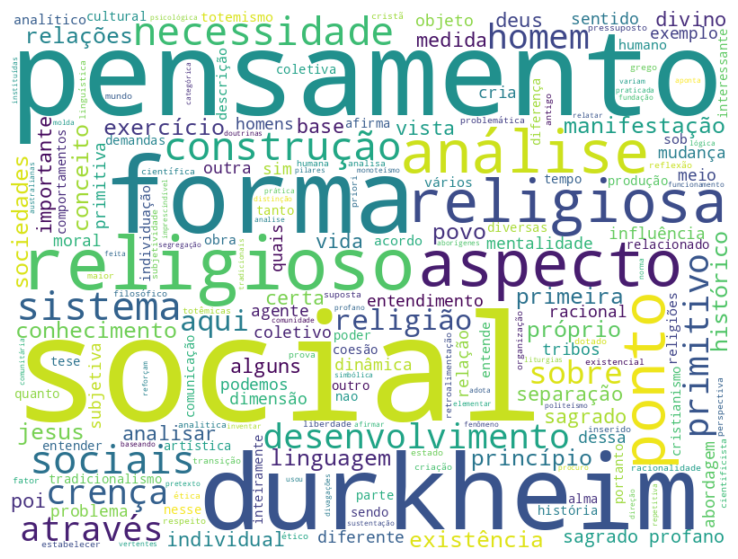

Sentimento geral do  primeiro texto (Pensamentos sobre a obra de Durkeim): Negativo
Sentimento geral do segundo texto ( Durkheim, Rachel Weiss),  Positivo


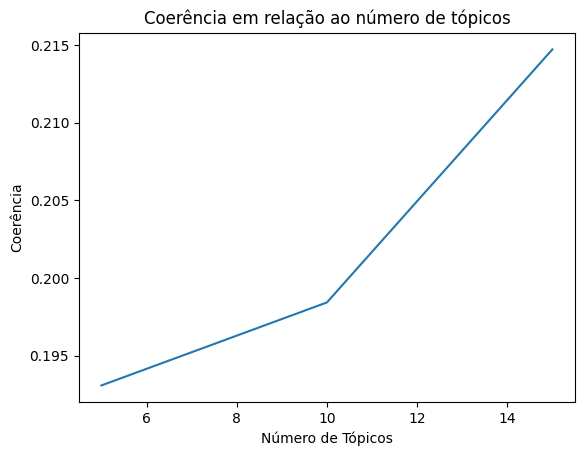

Tópicos principais:
(0, '0.002*"social" + 0.002*"pensamento" + 0.002*"durkheim" + 0.002*"forma" + 0.002*"religioso"')
(1, '0.002*"social" + 0.002*"forma" + 0.002*"pensamento" + 0.002*"durkheim" + 0.002*"religioso"')
(2, '0.016*"social" + 0.013*"pensamento" + 0.012*"durkheim" + 0.009*"religioso" + 0.009*"forma"')
(3, '0.002*"pensamento" + 0.002*"social" + 0.002*"durkheim" + 0.002*"forma" + 0.002*"religioso"')
(4, '0.002*"pensamento" + 0.002*"social" + 0.002*"durkheim" + 0.002*"religioso" + 0.002*"forma"')
(5, '0.002*"social" + 0.002*"pensamento" + 0.002*"forma" + 0.002*"durkheim" + 0.002*"homem"')
(6, '0.002*"social" + 0.002*"pensamento" + 0.002*"durkheim" + 0.002*"forma" + 0.002*"religioso"')
(7, '0.002*"social" + 0.002*"durkheim" + 0.002*"pensamento" + 0.002*"forma" + 0.002*"religioso"')
(8, '0.002*"pensamento" + 0.002*"social" + 0.002*"durkheim" + 0.002*"religioso" + 0.002*"forma"')
(9, '0.002*"social" + 0.002*"durkheim" + 0.002*"pensamento" + 0.002*"forma" + 0.002*"religioso"')
(10,

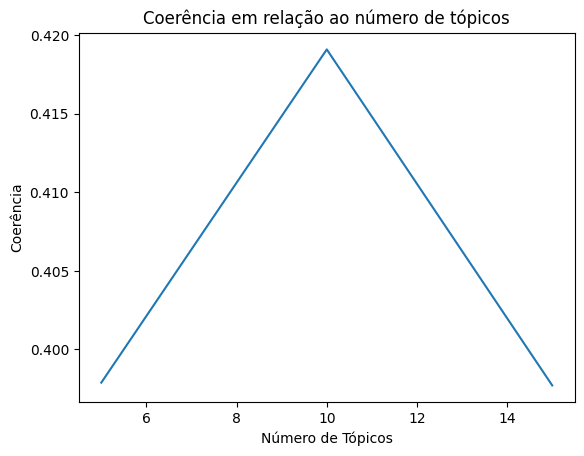

 Similaridade entre os documentos textuais: 0.0001


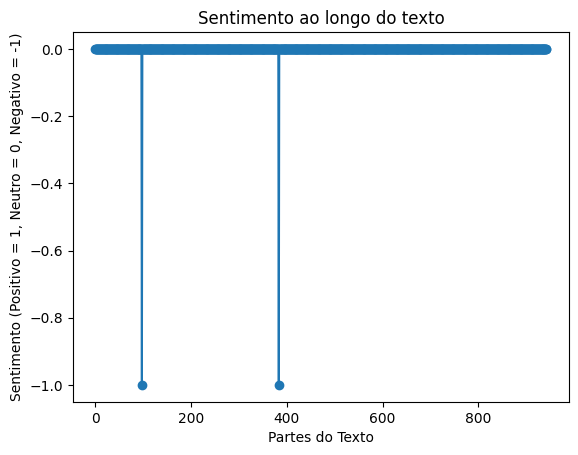

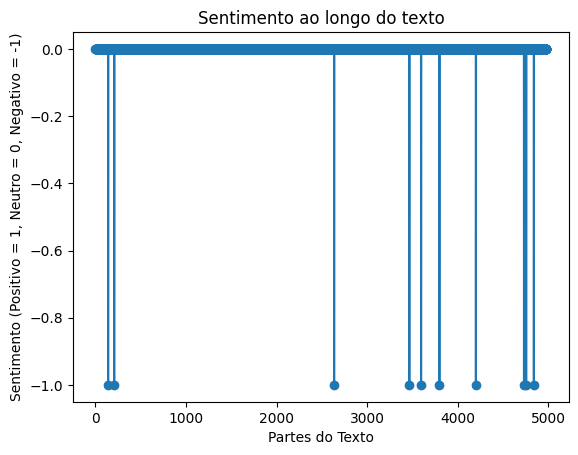

Número de nós na rede: 600
Número de arestas na rede: 914


Centralidade de Grau das palavras:
social: 0.0501
pensamento: 0.0401
durkheim: 0.0351
forma: 0.0301
religioso: 0.0234
religiosa: 0.0200
necessidade: 0.0200
através: 0.0200
sociais: 0.0184
desenvolvimento: 0.0184
Comunidades detectadas:
Comunidade 1: ['conhecimento', 'aspecto', 'necessidade', 'coletivo', 'abordagem', 'medida', 'crenças', 'tribos', 'próprio', 'sociedades', 'poi', 'ponto', 'sim', 'certa', 'mentalidade', 'através', 'racional', 'forma', 'homem', 'análise', 'vista', 'histórico', 'jesus', 'primitivo', 'quais', 'linguagem', 'vida', 'deus', 'religiosa', 'conceito', 'construção', 'aqui', 'sobre', 'princípio', 'relação', 'base', 'mudança', 'durkheim', 'povos', 'divino', 'existência', 'manifestação', 'exercício', 'religioso', 'primeira', 'subjetiva', 'moral', 'desenvolvimento', 'pensamento', 'social', 'homens', 'individual', 'religião', 'sistema']
Comunidade 2: ['exemplo', 'entendimento', 'alguns', 'aspectos', 'profano', 'sagrado', 'separação']
Comunidade 3: ['cria', 'sociais', 'r

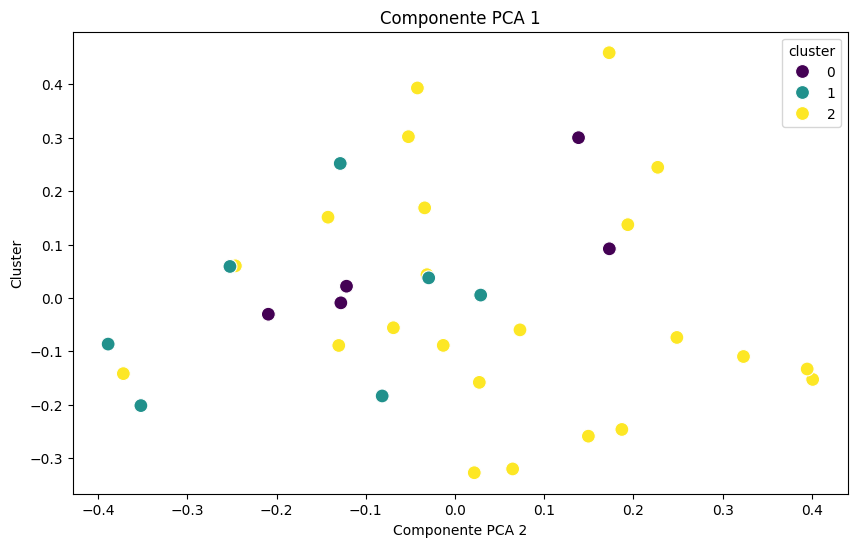

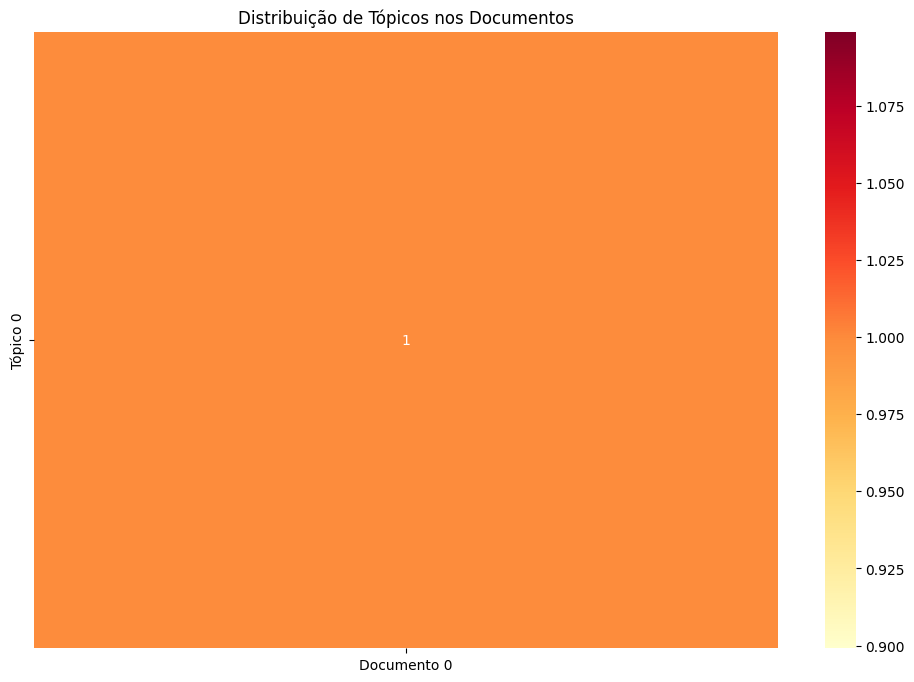

In [9]:
# Função principal
def main():
    file_path = "/content/Analise-de-sentimento/sentiment_analyses_project/data/Pensamentos Sobre a obra de Durkheim sobre a religião.pdf"
    text = read_pdf(file_path)
    The_clean_text = clean_text(text, use_lemmatization=True)

    # Texto 2 leitura e limpeza:
    file_path2 = "/content/Analise-de-sentimento/sentiment_analyses_project/data/Durkeim_ArtigoSobrereligiao.pdf"
    text2= read_pdf(file_path2)
    clean_text2 = clean_text(text2,use_lemmatization= True)

    # Análise de frequência de palavras(texto 1)
    word_freq = word_frequency(The_clean_text)
    print("Frequência das palavras (Top 20):")
    print(word_freq.head(20))

    # Geração da nuvem de palavras, texto 1
    generate_wordcloud(The_clean_text)

    # Análise de sentimentos
    sentiment = sentiment_analysis(The_clean_text,vader=True)
    sentiment2= sentiment_analysis(clean_text2,vader=True)
    print(f"Sentimento geral do  primeiro texto (Pensamentos sobre a obra de Durkeim): {sentiment}")
    print(f'Sentimento geral do segundo texto ( Durkheim, Rachel Weiss), {sentiment2}')

    #Modelagem de topicos LDA
    # Encontrar o número ideal de tópicos(Modelagem lda para o Texto 1)
    model_list, coherence_values = find_optimal_number_of_topics(The_clean_text)
    plot_coherence(coherence_values)
    optimal_model_index = coherence_values.index(max(coherence_values))
    lda_model = model_list[optimal_model_index]
    dictionary = Dictionary([The_clean_text])


    topics = lda_model.print_topics(num_words=5)
    print("Tópicos principais:")
    for topic in topics:
        print(topic)


    #Modelagem de topicos LDa (Texto 2)
    model_list2, coherence_values2 = find_optimal_number_of_topics(clean_text2)
    plot_coherence(coherence_values2)
    optimal_model_index2 = coherence_values2.index(max(coherence_values2))
    lda_model2 = model_list2[optimal_model_index2]
    dictionary2 = Dictionary([clean_text2])

    # Comparacao de documentos com base na similariedade dos topicos
    similarity= compare_documents(The_clean_text,clean_text2,lda_model,lda_model2,dictionary,dictionary2)
    print(f' Similaridade entre os documentos textuais: {similarity:.4f}')

    #Plotagem de mudanca de sentimentos ao longo do texto:
    sentiment_over_time(The_clean_text,window_size=True)
    sentiment_over_time(clean_text2,window_size=True)

    # Criação da rede de palavras com pesos baseados em LDA
    G = word_network_with_weights(The_clean_text, lda_model, dictionary)
    print(f"Número de nós na rede: {G.number_of_nodes()}")
    print(f"Número de arestas na rede: {G.number_of_edges()}")

    # 1. Filtragem de centralidade de grau
    G_filtered = filter_nodes_by_degree_centrality(G, threshold=0.01)

    # 2. Filtragem de arestas por peso
    G_filtered = filter_edges_by_weight(G_filtered, weight_threshold=0.5)

    # 3. Adicionando as comunidades como atributo nos nós
    communities = detect_comunnities_louvain(G_filtered)

    # 4. Filtragem do grafo para focar nas principais comunidades
    G_top_communities = filter_graph_by_community(G_filtered, communities, top_n=3)

    # 5. Visualização interativa
    plot_word_network_interactive(G_top_communities)
    plot_word_network_interactive_with_size(G_top_communities)

    # Cálculo da centralidade de grau
    degree_centrality = compute_degree_centrality(G)
    print("Centralidade de Grau das palavras:")
    for word, centrality in sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:10]:
        print(f"{word}: {centrality:.4f}")

    # Detecção de comunidades usando Girvan-Newman
    communities_gn = detect_communities(G_filtered, num_communities=5)
    print("Comunidades detectadas:")
    for idx, community in enumerate(communities_gn, 1):
        print(f"Comunidade {idx}: {community}")

# Extração de palavras-chave
    keywords = extract_keywords_tfidf(' '.join(The_clean_text))
    print("Palavras-chave extraídas (TF-IDF):")
    print(keywords)

    # Clusterização de sentenças
    sentences, labels = cluster_sentences(text,n_clusters=3)
    # Gerar a matriz TF-IDF novamente para reduzir a dimensionalidade
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(sentences)

    # Plotar os clusters
    plot_sentence_clusters(sentences, labels, X)

    # Visualização da distribuição de tópicos
    corpus1 = [dictionary.doc2bow(The_clean_text)]
    plot_topic_distribution(lda_model, corpus1, dictionary)


if __name__ == "__main__":
    main()




In [27]:
!git clone https://github.com/seu-usuario/eddie_herman/Analise-de-sentimento.git
!cd Analise-de-sentimento


fatal: destination path 'Analise-de-sentimento' already exists and is not an empty directory.


In [28]:
!git add .
!git commit -m "Removendo o token exposto"
!git push origin main


fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
